In [68]:
# Import the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import xgboost as xgb

# Ignore warning messages
warnings.filterwarnings("ignore")

# 1. Data Distribution and Insights from EDA
Question: How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

## Load the data

In [69]:
# Set paths for the data file
main_path = os.path.dirname(os.getcwd())
data_path = os.path.join(main_path, "data")
data_name = "dataset_SCL.csv"

# Load the data into a Pandas dataframe
df = pd.read_csv(os.path.join(data_path, data_name))

Conclusions:

- Data is loaded.
- There are problems with columns 1 and 6.

## Check for missing values

### Exploration

In [70]:
# Check for missing values in the dataframe
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

In [71]:
# Check for duplicated rows in the dataframe
df.duplicated().sum()

0

Conclusions:
- There is only one missing value in the data.
- There is no duplicated values.

Actions:
- Identify the missing value and determine a course of action to address it.

### Actions

Review the row with missing value.

In [72]:
# create a boolean mask for missing values
mask = df.isna().any(axis=1)

# select the rows with missing values
rows_with_missing = df[mask]
rows_with_missing

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


I examined the potential values that the Vlo-O column could exhibit when the Vlo-I column was held constant at a value of 200.

In [73]:
# Count the number of occurrences of each unique value in the "Vlo-O" column where "Vlo-I" is equal to 200
df[df["Vlo-I"]  == "200"]["Vlo-O"].value_counts()

200    209
Name: Vlo-O, dtype: int64

Since there is only one value ("200"), it will be replaced.

In [74]:
# Replace missing values with the string "200"
df.fillna("200", inplace=True)

## Data Summary

### Shape: Explotarion

In [75]:
# Get the number of rows and columns in the dataframe
df.shape

(68206, 18)

## Conclusions:
- The dataset contains 68206 rows and 18 columns.

### Column description: Exploration

In [76]:
# Get a summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68206 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


These columns represent the following information:

Section 1: Scheduled information of the flight
| Field | Description |
| --- | --- |
| Fecha-I | Scheduled date and time of the flight. |
| Vlo-I | Scheduled flight number. |
| Ori-I | Programmed origin city code. |
| Des-I | Programmed destination city code. |
| Emp-I | Scheduled flight airline code. |


Section 2: Real operated information of the flight
| Field | Description |
| --- | --- |
| Fecha-O | Date and time of flight operation. |
| Vlo-O | Flight operation number of the flight. |
| Ori-O | Operation origin city code. |
| Des-O | Operation destination city code. |
| Emp-O | Airline code of the operated flight. |

Section 3: Dates of flight operation
| Field | Description |
| --- | --- |
| DIA | Day of the month of flight operation. |
| MES | Number of the month of operation of the flight. |
| AÑO | Year of flight operation. |
| DIANOM | Day of the week of flight operation. |

Section 4: Type of the flight
| Field | Description |
| --- | --- |
| TIPOVUELO | Type of flight, I =International, N =National. |

Section 5: Name of codes used in previous sections
| Field | Description |
| --- | --- |
| OPERA | Name of the airline that operates. |
| SIGLAORI | Name city of origin. |
| SIGLADES | Destination city name. |

Conclusions:
- The variables Fecha-I and Fecha-O should be converted to datetime format.
- The rest of the variables are categorical (for example, a flight with a code 200 is not one unit less than a flight with code 201. Those numbers only represent different flights, i.e., different categories).
- The numeric variables can be kept as they are for now (for the purpose of visualizations), but it is important to note that they are actually categorical.


Ideas:

- The variables in section 1 can help understand if there are frequent routes, and if those routes have any particular delay patterns (necessary variables: Vlo-I, Ori-I, Des-I). Additionally, they can help see if any airline has a particular delay behavior (Emp-I).

    - Questions so far:
        - For this analysis, is it better to consider the -I or the -O?
        - How much does the -I differ from the -O?

- The variables in section 2 can help understand what happens when the planned -I differs from the executed -O.

- Questions so far:
    - For this analysis, is it better to consider the -I or the -O?
    - How much does the -I differ from the -O?

- The variables in section 3 can be used to analyze if certain seasonal patterns, such as seasons, days of the week (weekends), or others, affect flight delays.

- The variable in section 4 can help understand if national or international flights have different patterns of flight delays.

- Since the variables in section 5 are only the names of other codes, I am interested in storing them as dictionaries, since they probably won't be considered in the probability calculation analysis.

    - Observation: I checked that this section corresponds to how the flight operated, not how it was scheduled.

Other considerations:
- It is interesting to study the mix of some variables, for example: airline and route, route and season, airline and season, among others. 
- It is interesting to study the frequency of routes and delays and other characteristics/delays.
Other variables: Could the time in Santiago significantly influence whether a flight is delayed?

Actions:
- The Date-I and Date-O columns are transformed to datetime.

### Column description: Actions

In [77]:
# convert dates to datetime format
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])

### Preview of the data: Exploration

In [78]:
df.head(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami


In [79]:
df.tail(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68205,2017-12-31 14:55:00,400,SCEL,SPJC,JAT,2017-12-31 15:04:00,400.0,SCEL,SPJC,JAT,31,12,2017,Domingo,I,JetSmart SPA,Santiago,Lima


Conclusions:
- We notice that in the Vlo-O column, there are values that are as float and as string. This column must be str, since it is a category (eg: A flight with code 200 does not have one unit less than something than a flight with code 201. Those numbers only represent different flights).

Actions:
- Fixed the previous issue.

### Preview of the data: Action

In [80]:
# Check if float values are not in type XX.0
for value in df["Vlo-I"].unique():
    if isinstance(value, float):
        if not int(value) == value:
            print(value)

In [81]:
# Check if float values are not in type XX.0
for value in df["Vlo-O"].unique():
    if isinstance(value, float):
        if not int(value) == value:
            print(value)

In [82]:
# Conver to int and then to str just the float values
def float_to_str(x):
    try:
        return str(int(float(x)))
    except:
        return x
    # if type(x) == type(2.) and not np.isnan(x):
    #     return str(int(x))
    # return x

df["Vlo-I"] = df["Vlo-I"].apply(lambda x: float_to_str(x))
df["Vlo-O"] = df["Vlo-O"].apply(lambda x: float_to_str(x))
df["Vlo-I"] = df["Vlo-I"].astype(str)
df["Vlo-O"] = df["Vlo-O"].astype(str)

## Pre  Analysis: Check differences between -I (scheduled) and -O (operated).
Check some variables before further exploration

### Question: From where the flights departue?

In [83]:
# Check if departuress-I differs from departures-O
departures_I, departures_O = df["Ori-I"].value_counts(), df["Ori-O"].value_counts()
departures_I, departures_O

(SCEL    68206
 Name: Ori-I, dtype: int64,
 SCEL    68206
 Name: Ori-O, dtype: int64)

### Answer: Flights only take off from SCEL, so these columns do not add any information.

Actions:
- These columns are removed

In [84]:
# columns are removed
df.drop(["Ori-I", "Ori-O", "SIGLAORI"], inplace = True, axis = 1)

### Question: Where do the flights go? Is there any difference between Vlo-I and Vlo-O?

In [85]:
departures_I = df["Des-I"].value_counts()
departures_I

SCFA    5787
SPJC    5270
SCCF    5145
SCTE    4357
SCIE    3995
        ... 
SBFI       1
SPSO       1
SEQU       1
SEQM       1
SARI       1
Name: Des-I, Length: 64, dtype: int64

In [86]:
departures_O = df["Des-O"].value_counts()
departures_O

SCFA    5786
SPJC    5270
SCCF    5146
SCTE    4357
SCIE    3993
        ... 
SEQM       2
KIAD       1
SPSO       1
EGYP       1
SLCB       1
Name: Des-O, Length: 63, dtype: int64

How many times are these values the same?

In [87]:
len(df[df["Des-I"] == df["Des-O"]])/(len(df))

0.9995894789314723

They are the same in 99% of cases.

Conclusions:
- There are various destinations.
- Des-I is equal to Des-O in 99% of cases.

### Answer: There are 63 destinations where flights arrive. It works with Des-O.

In [88]:
df.drop(["Des-I"], axis=1, inplace=True)

### Question: Is Vlo-I, Vlo-O usedful?

In [89]:
# Check how many times are those variables equal
np.sum(df["Vlo-I"] == df["Vlo-O"])/len(df)

0.9982552854587573

In [90]:
# Check when they are not equal
mask = df["Vlo-I"] != df["Vlo-O"]
df[mask].head(n=10)

,Fecha-I,Vlo-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLADES
6018,2017-01-05 07:05:00,4501,LAN,2017-01-05 09:36:00,1001,SAEZ,LAN,5,1,2017,Jueves,I,Grupo LATAM,Buenos Aires
6020,2017-01-07 07:05:00,4501,LAN,2017-01-07 06:59:00,1001,SAEZ,LAN,7,1,2017,Sabado,I,Grupo LATAM,Buenos Aires
6022,2017-01-12 07:05:00,4501,LAN,2017-01-12 08:05:00,1003,SAEZ,LAN,12,1,2017,Jueves,I,Grupo LATAM,Buenos Aires
6023,2017-01-13 07:05:00,4501,LAN,2017-01-13 07:06:00,1001,SAEZ,LAN,13,1,2017,Viernes,I,Grupo LATAM,Buenos Aires
6025,2017-01-19 10:50:00,4501,LAN,2017-01-19 10:56:00,1001,SAEZ,LAN,19,1,2017,Jueves,I,Grupo LATAM,Buenos Aires
6030,2017-01-27 07:05:00,4501,LAN,2017-01-27 07:14:00,1003,SAEZ,LAN,27,1,2017,Viernes,I,Grupo LATAM,Buenos Aires
6035,2017-01-04 13:40:00,4503,LAN,2017-01-04 13:46:00,1004,SAEZ,LAN,4,1,2017,Miercoles,I,Grupo LATAM,Buenos Aires
6040,2017-01-19 17:20:00,4503,LAN,2017-01-19 17:37:00,1003,SAEZ,LAN,19,1,2017,Jueves,I,Grupo LATAM,Buenos Aires
6055,2017-01-03 19:50:00,1302,LAN,2017-01-03 21:27:00,2640,SPJC,LAN,3,1,2017,Martes,I,Grupo LATAM,Lima
6086,2017-01-18 01:15:00,700,LAW,2017-01-18 01:36:00,702,SPJC,56R,18,1,2017,Miercoles,I,Latin American Wings,Lima


Conclusion:
- They are equal in a 99.8% of the cases.
- These codes represents a link between airlines and destinations.
- Is interesting to study if some of those combinaitones have particular delay reates.
- Vlo-O is going to be used for the analysis.

Actions:
- The Vlo-I variable is eliminated, since it is not useful.

In [91]:
df.drop(["Vlo-I"], axis = 1, inplace = True)

### Answer: hese codes represents a link between airlines and destinations.  Vlo-O migth going to be used for the analysis.

### Question: How Emp-I, Emp-O and Opera are related? Which one(S) to keep?

Are they equal all the time?

In [92]:
# Check how many times are those variables equal
np.sum(df["Emp-I"] == df["Emp-O"])/len(df)

0.726285077559159

No, just in 72% of the cases.

Each EMP-O has an unique OPERA?

In [93]:
opera_Emp_dict = {opera: df.loc[df['OPERA'] == opera, 'Emp-O'].unique().tolist() for opera in df['OPERA'].unique()}
opera_Emp_dict

{'American Airlines': ['AAL'],
 'Air Canada': ['ACA'],
 'Air France': ['AFR'],
 'Aeromexico': ['AMX'],
 'Aerolineas Argentinas': ['ARG', 'AUT'],
 'Austral': ['AUT', 'ARG'],
 'Avianca': ['AVA', 'LRC', 'TPU'],
 'Alitalia': ['AZA'],
 'British Airways': ['BAW'],
 'Copa Air': ['CMP'],
 'Delta Air': ['DAL'],
 'Gol Trans': ['GLO'],
 'Iberia': ['IBE'],
 'K.L.M.': ['KLM'],
 'Qantas Airways': ['QFA'],
 'United Airlines': ['UAL'],
 'Grupo LATAM': ['LAP', 'TAM', 'LAN', 'LXP', 'LNE', 'LPE', 'DSM'],
 'Sky Airline': ['SKU'],
 'Latin American Wings': ['48O', '56R', 'JMR'],
 'Plus Ultra Lineas Aereas': ['PUE'],
 'JetSmart SPA': ['JAT'],
 'Oceanair Linhas Aereas': ['ONE'],
 'Lacsa': ['LRC']}

No, and actually all the Emp-O are in a unique claster of OPERA. Except for ['ARG', 'AUT'], que estan en 'Aerolineas Argentinas' y 'Austral'.

In [94]:
mask = df["Emp-I"] != df["Emp-O"]
df[mask][["Emp-I","Emp-O", "OPERA"]].value_counts()

Emp-I  Emp-O  OPERA                
LAN    LXP    Grupo LATAM              14549
LAW    JMR    Latin American Wings      1547
LAN    LPE    Grupo LATAM               1210
       DSM    Grupo LATAM                491
       LNE    Grupo LATAM                373
AVA    LRC    Avianca                    265
QFU    QFA    Qantas Airways             195
LAW    56R    Latin American Wings        17
       48O    Latin American Wings        10
ARG    AUT    Aerolineas Argentinas        5
TAM    LAP    Grupo LATAM                  3
AUT    ARG    Austral                      2
AVA    TPU    Avianca                      2
dtype: int64

Conclusion:
- We note that in almost all cases, when EMP-I is different from EMP-O, the same OPERATOR is maintained.

Exceptions:
- LAW was not in the dictionary, checking the internet (also it is clear), it is part of Latin American Wings.
- QFU and QFA are the only difference, since there is no information on QFU. QFU does not appear on the internet, but given the similarity of names, it is assumed that it is still Qantes Airways.
- It is decided that the person who really operates the flights is OPERA, therefore this column is used.

### Answer: It is decided that the person who really operates the flights is OPERA, therefore this column is used.

Actions:
- Removed Emp-I and Emp-O

In [95]:
df.drop(["Emp-I", "Emp-O"], axis=1, inplace=True)

## Data Exploration

### Numeric variables distributions

In [96]:
df.describe()

,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


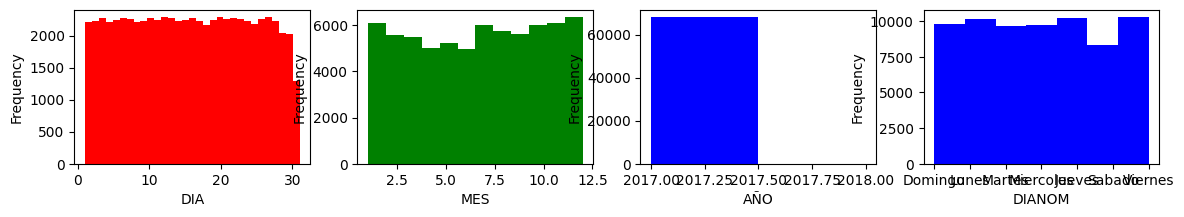

In [97]:
fig, ax = plt.subplots(1, 4, figsize=(14, 2))

ax[0].hist(df['DIA'], bins=31, color='red')
ax[0].set_xlabel('DIA')
ax[0].set_ylabel('Frequency')

ax[1].hist(df['MES'], bins=12, color='green')
ax[1].set_xlabel('MES')
ax[1].set_ylabel('Frequency')

ax[2].hist(df['AÑO'], bins=2, color='blue')
ax[2].set_xlabel('AÑO')
ax[2].set_ylabel('Frequency')

ax[3].hist(df['DIANOM'], bins=7, color='blue')
ax[3].set_xlabel('DIANOM')
ax[3].set_ylabel('Frequency')

plt.show()

Conclusions:
- At first glance there is nothing strange with these variables. The days, months, years and dianom are in a proper range. You don't see the data centered on any particular value.
- The data is mostly from 2017, with the exception of two flights that passed just after midnight on the last day of 2017. (due to delays)

### Categoric variables distributions

In [98]:
def distribution_cat_variables(variable):
    # Group the data by airline and count the number of flights for each airline
    airline_counts = df[variable].value_counts()

    # Normalize the values to show proportions
    airline_proportions = airline_counts / airline_counts.sum()

    # Create a bar graph of airline market share
    plt.figure(figsize=(10, 2))
    airline_proportions.plot(kind='bar',cmap='viridis')
    plt.title(f'Number of flights by {variable}')
    plt.xlabel(f'{variable}')
    plt.ylabel('Proportion of Flights')
    plt.show()

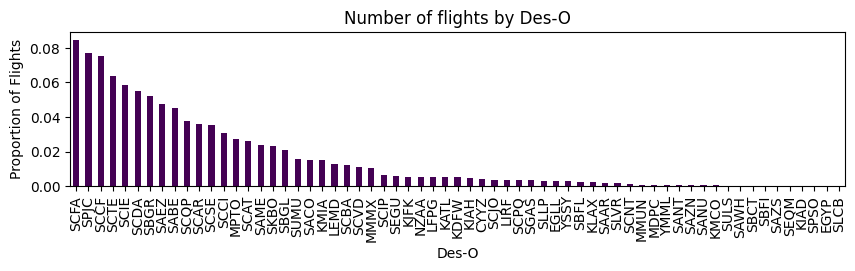

In [99]:
distribution_cat_variables('Des-O')

Conclusion:
- There are destinations with many more flights than others.
- Is important to notice that there are destinations with really low number of flights.
- For those destinations is going to be a problem when trying to predict delay flights. Is important to notice that and take into account when doing feature engineering.

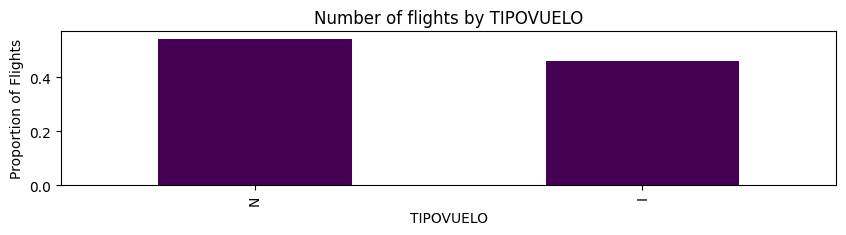

In [100]:
distribution_cat_variables('TIPOVUELO')

Conclusion:
- There are some more national flights than international flights

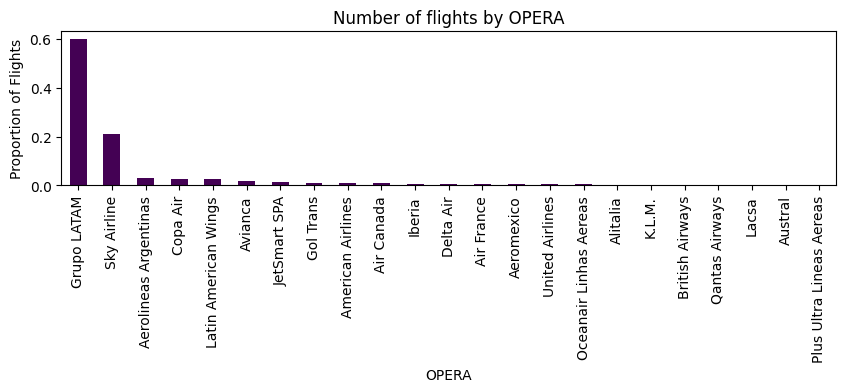

In [101]:
distribution_cat_variables('OPERA')

Concluiones:
- Latam y Sky tienen un 80% de los vuelos.
- Same as destinations, there are some airlines with really low numbers of flights. Is important to take into account when doing feature engineering.

### Time variables

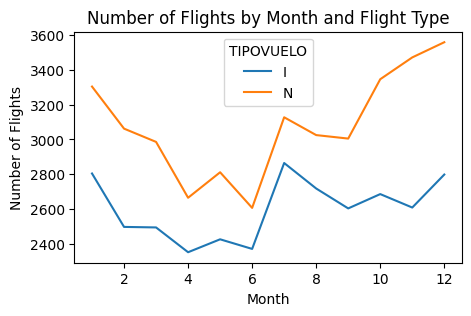

In [102]:
# Group the data by month and flight type and count the number of flights for each group
month_type_counts = df.groupby(['MES', 'TIPOVUELO']).size().unstack()

# Create a line chart of number of flights by month and flight type
ax = month_type_counts.plot(kind='line', figsize=(5, 3))
ax.set_title('Number of Flights by Month and Flight Type')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Flights')
plt.show()

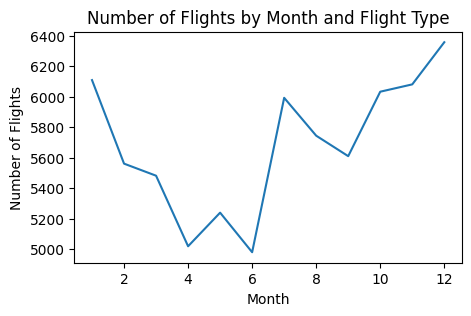

In [103]:
# Group the data by month and flight type and count the number of flights for each group
month_type_counts = df.groupby(['MES']).size()

# Create a line chart of number of flights by month and flight type
ax = month_type_counts.plot( figsize=(5, 3))
ax.set_title('Number of Flights by Month and Flight Type')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Flights')
plt.show()

Conclusions:
- The seasonality of national and international flights is the same.

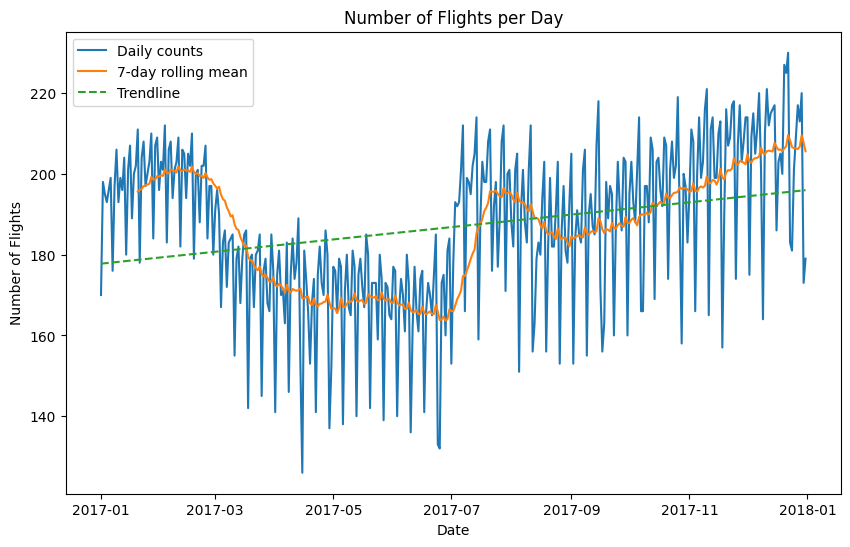

In [104]:
# Resample the data to daily frequency and calculate the rolling mean with a window size of 7 days
daily_counts = df.set_index('Fecha-I').resample('D').size()
rolling_mean = daily_counts.rolling(window=20).mean()

# Plot the daily flight counts and the rolling mean
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_counts.index, daily_counts.values, label='Daily counts')
ax.plot(rolling_mean.index, rolling_mean.values, label='7-day rolling mean')
ax.legend()

# Calculate and plot the trendline
x = np.arange(len(daily_counts))
coeffs = np.polyfit(x, daily_counts, 1)
trendline = np.poly1d(coeffs)
ax.plot(daily_counts.index, trendline(x), label='Trendline', linestyle='--')
ax.legend()

ax.set_title('Number of Flights per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Flights')
plt.show()

Conclusions:
- We note that there are two peaks in the demand for flights
- A peak can be related to the winter holidays in Chile (end of July - beginning of August)
- The other peak can be related to the summer holidays in Chile (late November - early March)

# 2. Generate additional columns
Instructions: Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:
○ high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
○ min_diff : difference in minutes between Date-O and Date-I .
○ delay_15 : 1 if min_diff > 15, 0 if not.
○ period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .

## high_season
1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

In [105]:
df["high_season"] = (
      ((df['Fecha-I'].dt.month == 12) & (df['Fecha-I'].dt.day >= 15)) | 
      (df['Fecha-I'].dt.month == 1) | 
      (df['Fecha-I'].dt.month == 2) | 
      ((df['Fecha-I'].dt.month == 3) & (df['Fecha-I'].dt.day <= 3)) | 
      ((df['Fecha-I'].dt.month == 7) & (df['Fecha-I'].dt.day >= 15) & (df['Fecha-I'].dt.day <= 31)) | 
      ((df['Fecha-I'].dt.month == 9) & (df['Fecha-I'].dt.day >= 11) & (df['Fecha-I'].dt.day <= 30))
   ).astype(int)

df["high_season_2"] = (
      ((df['Fecha-I'].dt.month == 12) & (df['Fecha-I'].dt.day >= 15)) | 
      (df['Fecha-I'].dt.month == 1) | 
      ((df['Fecha-I'].dt.month == 3) & (df['Fecha-I'].dt.day <= 3)) | 
      ((df['Fecha-I'].dt.month == 7) & (df['Fecha-I'].dt.day >= 15) & (df['Fecha-I'].dt.day <= 31))
      ).astype(int)

## min_diff
difference in minutes between Date-O and Date-I .

In [106]:
df['min_diff'] = df.apply(lambda x: (x['Fecha-O'] - x['Fecha-I']).total_seconds() / 60, axis=1)

## delay_15
1 if min_diff > 15, 0 if not.

In [107]:
df['delay_15'] = (df['min_diff'] > 15).astype(int)

Since we have this variable, we study how many flights are delayed within the database.

In [108]:
mask = df["delay_15"] == 1
len(df[mask])/len(df)

0.18493974137172683

20% of the database is behind. Although the database has a greater number of flights that are not delayed, the number of flights that are delayed is representative. Even so, techniques could be used to better balance the classes.

## period_day
morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I .

In [109]:
# Create the period_day variable
df.loc[(df['Fecha-I'].dt.hour >= 5) & (df['Fecha-I'].dt.hour < 12), 'period_day'] = 'morning'
df.loc[(df['Fecha-I'].dt.hour >= 12) & (df['Fecha-I'].dt.hour < 19), 'period_day'] = 'afternoon'
df.loc[((df['Fecha-I'].dt.hour >= 19) & (df['Fecha-I'].dt.hour <= 23)) | ((df['Fecha-I'].dt.hour >= 0) & (df['Fecha-I'].dt.hour < 5)), 'period_day'] = 'night'

## Save to .CSV

In [110]:
df[["high_season", "min_diff", "delay_15", "period_day"]].to_csv(os.path.join(data_path, "synthetic_features.csv"))

# 3. Behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight.
Question: . What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?What
variables would you expect to have the most influence in predicting delays?

## Q : What variables would you expect to have the most influence in predicting delays?

### Delay rate across destination

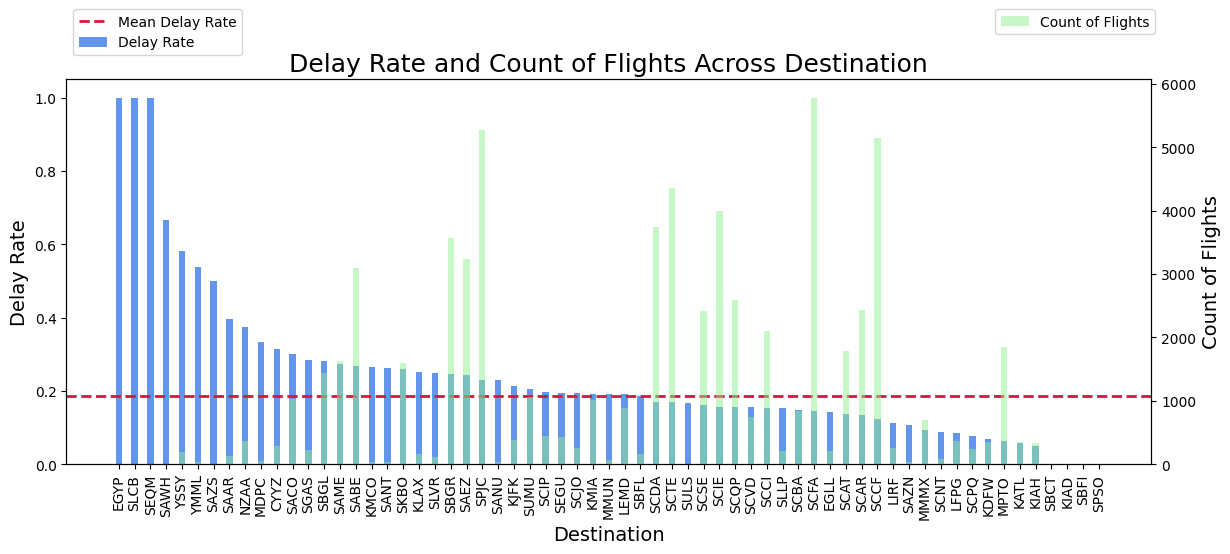

In [111]:
# Calculate delay rate and count of flights by destination
delay_rate = df.groupby('Des-O')['delay_15'].mean().sort_values(ascending=False)
flight_count = df['Des-O'].value_counts()

# Sort flight_count by delay_rate index
flight_count = flight_count.loc[delay_rate.index]

# Calculate mean delay rate
mean_delay_rate = df['delay_15'].mean()

# Create barplot
fig, ax = plt.subplots(figsize=(14, 5))

ax.bar(delay_rate.index, delay_rate.values, color='cornflowerblue', width=0.4, label='Delay Rate')

ax2 = ax.twinx()
ax2.bar(flight_count.index, flight_count.values, color='lightgreen', alpha=0.5, width=0.4, label='Count of Flights')

# Add mean line
ax.axhline(mean_delay_rate, color='crimson', linestyle='--', linewidth=2, label='Mean Delay Rate')

# Set labels and titles
ax.set_xlabel('Destination', fontsize=14)
ax.set_ylabel('Delay Rate', fontsize=14)
ax2.set_ylabel('Count of Flights', fontsize=14)
ax.set_title('Delay Rate and Count of Flights Across Destination', fontsize=18)
ax.tick_params(axis='x', labelrotation=90)

ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0, 1.2))
ax2.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.85, 1.2))

# Add values on top of each bar
# for i, v in enumerate(delay_rate.values):
#     ax.text(i, v, f'{v:.2f}', fontsize=8)
# for i, v in enumerate(flight_count.values):
#     ax2.text(i, v, str(v), fontsize=8)

plt.show()

Conclusions:
- We notice that there are destinations with a much higher delay rate than others.
- It is seen that there are also destinations with delay rate 1 or 0, some with a low number of flights but others not.
- There are also some destinations with a rate above the average, but which have a low number of flights.
- Destinations with few flights will not have a correct estimate, you have to be careful with that.

### Delay rate across airline

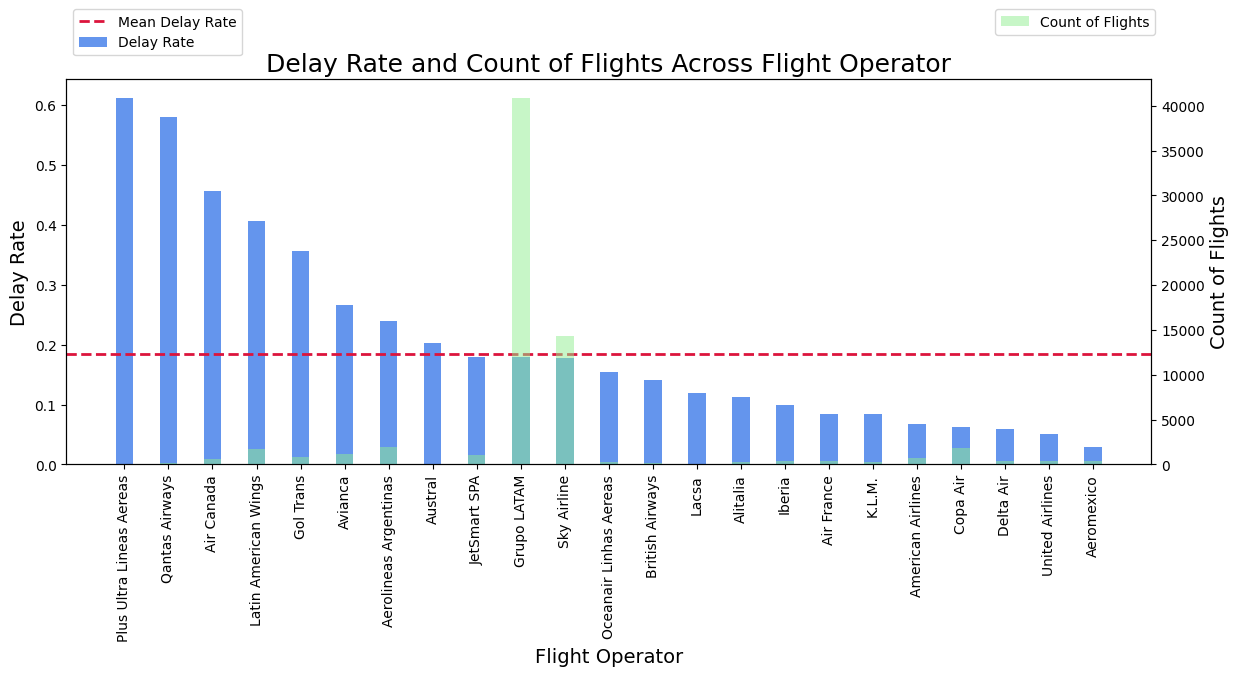

In [112]:
# Calculate delay rate and count of flights by Flight Operator
delay_rate = df.groupby('OPERA')['delay_15'].mean().sort_values(ascending=False)
flight_count = df['OPERA'].value_counts()

# Sort flight_count by delay_rate index
flight_count = flight_count.loc[delay_rate.index]

# Calculate mean delay rate
mean_delay_rate = df['delay_15'].mean()

# Create barplot
fig, ax = plt.subplots(figsize=(14, 5))

ax.bar(delay_rate.index, delay_rate.values, color='cornflowerblue', width=0.4, label='Delay Rate')

ax2 = ax.twinx()
ax2.bar(flight_count.index, flight_count.values, color='lightgreen', alpha=0.5, width=0.4, label='Count of Flights')

# Add mean line
ax.axhline(mean_delay_rate, color='crimson', linestyle='--', linewidth=2, label='Mean Delay Rate')

# Set labels and titles
ax.set_xlabel('Flight Operator', fontsize=14)
ax.set_ylabel('Delay Rate', fontsize=14)
ax2.set_ylabel('Count of Flights', fontsize=14)
ax.set_title('Delay Rate and Count of Flights Across Flight Operator', fontsize=18)
ax.tick_params(axis='x', labelrotation=90)

ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0, 1.2))
ax2.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.85, 1.2))

# Add values on top of each bar
# for i, v in enumerate(delay_rate.values):
#     ax.text(i, v, f'{v:.2f}', fontsize=8)
# for i, v in enumerate(flight_count.values):
#     ax2.text(i, v, str(v), fontsize=8)

plt.show()

Conclusion:
- There are different types of delay rate for each airline
- LATAM and Ski Airline have close to 80% of the flights.
- The performance of those airlines could have a significant impact on the overall delay rate
- We may want to consider giving more weight to the delay rate of those airlines
- We have a small sample size for some airlines (21 out of 23). I'm concerned about the reliability of the delay rate estimates, then it might be better to not include delay rate per airline as a feature in the model.

### Delay rate across day of the week

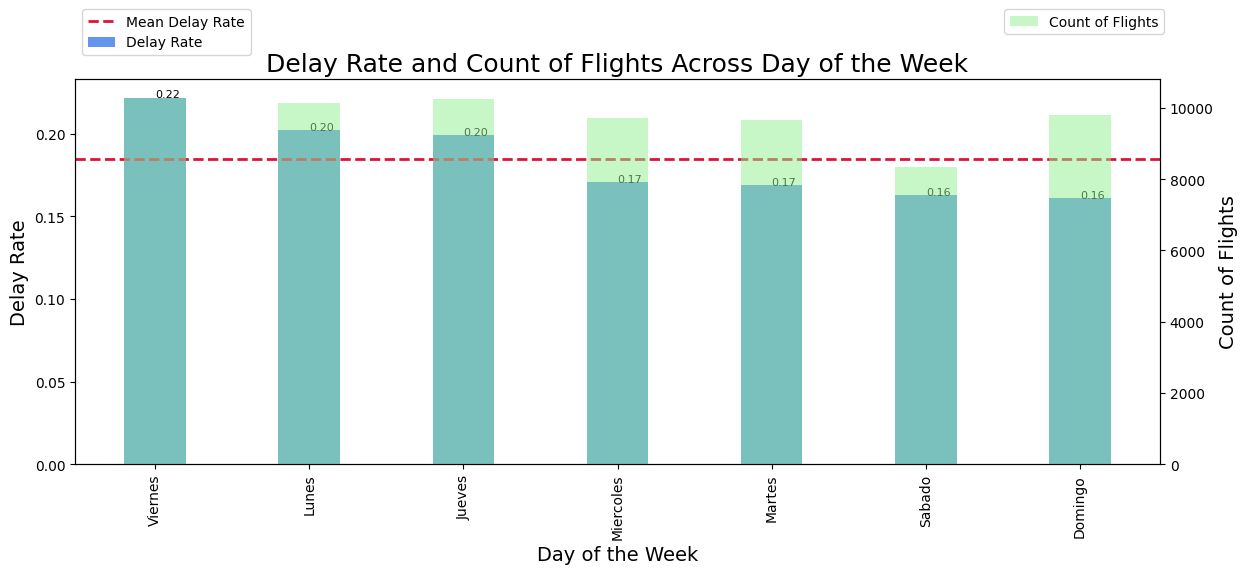

In [113]:
# Calculate delay rate and count of flights by Day of the Week
delay_rate = df.groupby('DIANOM')['delay_15'].mean().sort_values(ascending=False)
flight_count = df['DIANOM'].value_counts()

# Sort flight_count by delay_rate index
flight_count = flight_count.loc[delay_rate.index]

# Calculate mean delay rate
mean_delay_rate = df['delay_15'].mean()

# Create barplot
fig, ax = plt.subplots(figsize=(14, 5))

ax.bar(delay_rate.index, delay_rate.values, color='cornflowerblue', width=0.4, label='Delay Rate')

ax2 = ax.twinx()
ax2.bar(flight_count.index, flight_count.values, color='lightgreen', alpha=0.5, width=0.4, label='Count of Flights')

# Add mean line
ax.axhline(mean_delay_rate, color='crimson', linestyle='--', linewidth=2, label='Mean Delay Rate')

# Set labels and titles
ax.set_xlabel('Day of the Week', fontsize=14)
ax.set_ylabel('Delay Rate', fontsize=14)
ax2.set_ylabel('Count of Flights', fontsize=14)
ax.set_title('Delay Rate and Count of Flights Across Day of the Week', fontsize=18)
ax.tick_params(axis='x', labelrotation=90)

ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0, 1.2))
ax2.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.85, 1.2))

# Add values on top of each bar
for i, v in enumerate(delay_rate.values):
    ax.text(i, v, f'{v:.2f}', fontsize=8)
# for i, v in enumerate(flight_count.values):
#     ax2.text(i, v, str(v), fontsize=8)

plt.show()

Conclusion:
- There is a difference in the delay rate per day of the week.
- There does not seem to be a direct correlation with the number of flights.
- It is a good variable to add to the model as a numeric variable.

### Delay rate across month

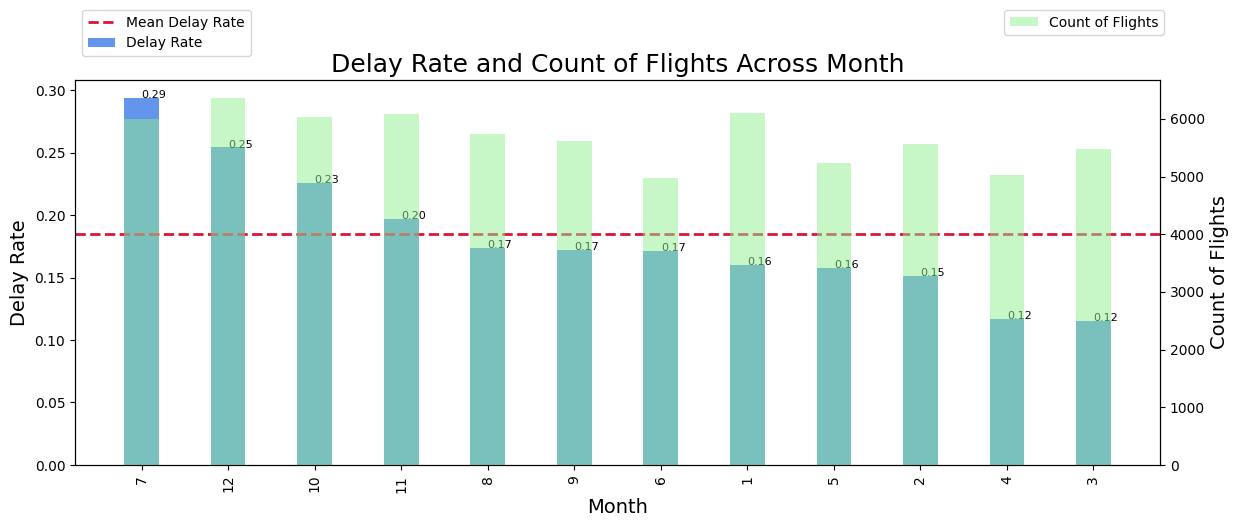

In [114]:
# Calculate delay rate and count of flights by Month
delay_rate = df.groupby('MES')['delay_15'].mean().sort_values(ascending=False)
flight_count = df['MES'].value_counts()

# Sort flight_count by delay_rate index
flight_count = flight_count.loc[delay_rate.index]

# Calculate mean delay rate
mean_delay_rate = df['delay_15'].mean()

# Create barplot
fig, ax = plt.subplots(figsize=(14, 5))

ax.bar(delay_rate.index.astype(str), delay_rate.values, color='cornflowerblue', width=0.4, label='Delay Rate')

ax2 = ax.twinx()
ax2.bar(flight_count.index.astype(str), flight_count.values, color='lightgreen', alpha=0.5, width=0.4, label='Count of Flights')

# Add mean line
ax.axhline(mean_delay_rate, color='crimson', linestyle='--', linewidth=2, label='Mean Delay Rate')

# Set labels and titles
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Delay Rate', fontsize=14)
ax2.set_ylabel('Count of Flights', fontsize=14)
ax.set_title('Delay Rate and Count of Flights Across Month', fontsize=18)
ax.tick_params(axis='x', labelrotation=90)

ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0, 1.2))
ax2.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.85, 1.2))

# Add values on top of each bar
for i, v in enumerate(delay_rate.values):
    ax.text(i, v, f'{v:.2f}', fontsize=8)
# for i, v in enumerate(flight_count.values):
#     ax2.text(i, v, str(v), fontsize=8)

plt.show()

Conclusion:
- The months with the highest number of flights are not necessarily the ones with the highest number of delays. For example, month 1 has a large number of flights, but does not have a large number of delays (below average).

### Delay rate across season

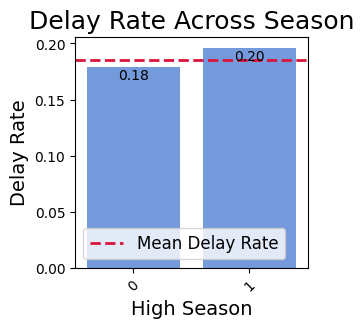

In [115]:
# Calculate delay rate by high_season
delay_rate_season = df.groupby('high_season')['delay_15'].mean().sort_values(ascending=False)

# Calculate mean delay rate
mean_delay_rate = df['delay_15'].mean()

# Create barplot
fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(x=delay_rate_season.index, y=delay_rate_season.values, ax=ax, color='cornflowerblue')

# Add mean line
ax.axhline(mean_delay_rate, color='crimson', linestyle='--', linewidth=2, label='Mean Delay Rate')

# Set labels and titles
ax.set_xlabel('High Season', fontsize=14)
ax.set_ylabel('Delay Rate', fontsize=14)
ax.set_title('Delay Rate Across Season', fontsize=18)
ax.tick_params(axis='x', labelrotation=45)
ax.legend(fontsize=12)

# Add values on top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{x:.2f}" for x in i.datavalues], fontsize=10, padding=-11)

plt.show()

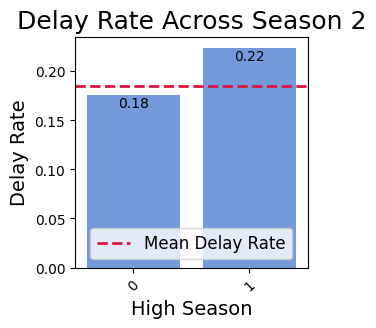

In [116]:
# Calculate delay rate by high_season
delay_rate_season = df.groupby('high_season_2')['delay_15'].mean().sort_values(ascending=False)

# Calculate mean delay rate
mean_delay_rate = df['delay_15'].mean()

# Create barplot
fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(x=delay_rate_season.index, y=delay_rate_season.values, ax=ax, color='cornflowerblue')

# Add mean line
ax.axhline(mean_delay_rate, color='crimson', linestyle='--', linewidth=2, label='Mean Delay Rate')

# Set labels and titles
ax.set_xlabel('High Season', fontsize=14)
ax.set_ylabel('Delay Rate', fontsize=14)
ax.set_title('Delay Rate Across Season 2', fontsize=18)
ax.tick_params(axis='x', labelrotation=45)
ax.legend(fontsize=12, loc='lower center')

# Add values on top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{x:.2f}" for x in i.datavalues], fontsize=10, padding=-11)

plt.show()

Conclusions:
- There is a difference between seasons, although not greater.
- Perhaps the HIGH SEASON is defined in other periods, as can be seen in the peaks of the graphs of the number of flights per day.
- Based on that, high season 2 was created, which is preferred to be added as a variable, since it generates greater segregation.
- It is added as a numeric variable.

### Delay rate across  type of flight

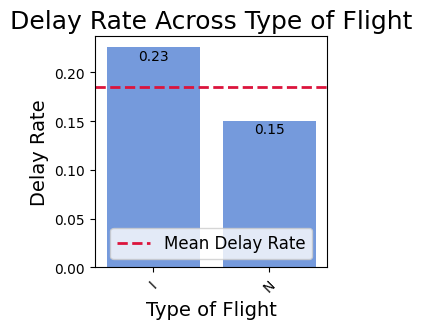

In [117]:
# Calculate delay rate by high_season
delay_rate_type_flight = df.groupby('TIPOVUELO')['delay_15'].mean().sort_values(ascending=False)

# Calculate mean delay rate
mean_delay_rate = df['delay_15'].mean()

# Create barplot
fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(x=delay_rate_type_flight.index, y=delay_rate_type_flight.values, ax=ax, color='cornflowerblue')

# Add mean line
ax.axhline(mean_delay_rate, color='crimson', linestyle='--', linewidth=2, label='Mean Delay Rate')

# Set labels and titles
ax.set_xlabel('Type of Flight', fontsize=14)
ax.set_ylabel('Delay Rate', fontsize=14)
ax.set_title('Delay Rate Across Type of Flight', fontsize=18)
ax.tick_params(axis='x', labelrotation=45)
ax.legend(fontsize=12, loc='lower center')

# Add values on top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{x:.2f}" for x in i.datavalues], fontsize=10, padding=-11)


plt.show()

Conclusions:
- It is a variable that is worth adding since it is capable of differentiating.

## A: Type of flight, high season 2, and month will have the most impact. I'm not sure about how destination and fly operator will work.

# 4. Train Model
Instructions: Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
Feel free to generate additional variables and/or supplement with external variables

In [118]:
df.sort_values(by='Fecha-I', ascending=True, inplace = True)

## Model explained

Is important to notice that we have only one year of data. Because of this I think a good isea is to use Cross-validation is useful for predicting flight delays because it allows us to test the performance of a model on a set of data that the model has not seen before.

So for the year of data, I take an 80% of the data for doing the cross-validation process and a 20% for validation purposes.

Inside each cross validation loop, variables are generated using all the data available. Then these variables that were created using juse trianing data, are imputed on the test data, and then the likelihood estimation per flight is calculated.

The base columns to use are the following:

In [119]:
df_pre_model = df.copy()
columns = ['Vlo-O', 'Des-O', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'high_season_2', 'period_day', 'delay_15']
df = df_pre_model[columns]
df.head()

,Vlo-O,Des-O,MES,DIANOM,TIPOVUELO,OPERA,high_season_2,period_day,delay_15
169,11,MMMX,1,Domingo,I,Aeromexico,1,night,0
5078,572,SKBO,1,Domingo,I,Grupo LATAM,1,night,0
622,495,MPTO,1,Domingo,I,Copa Air,1,night,0
409,240,SKBO,1,Domingo,I,Avianca,1,night,0
592,276,MPTO,1,Domingo,I,Copa Air,1,night,0


Each of those columns is a categorical variable, and is treated with one hot encoder to create a column for each category (except for the first one to avoid colliniarity). 

Also, historical delay rates are created. It delay rate is created for each category of the following variables: 'Vlo-O', 'Des-O', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'high_season_2', 'period_day. Again, note that to create that rates is necesary the independent variable, but that variable is just using to create the rates in the training set, not the test set.

Is important to notice that for the variables OPERA and Des-O, the rate is only calculated for a particular category if that category has at least 1% of the total number of flights (as we saw previously, there some airlines and destinations with really low number of flights).

In [120]:
# Define a function to perform feature engineering on each fold of data
def feature_engineering(X_train, X_test, y_train, columns_2,airline_threshold=0.01, route_threshold=0.01):
    
    X_train = pd.concat([X_train, y_train.rename('delay_15')], axis=1)
    X_test = pd.concat([X_test, y_train[0:len(X_test)].rename('delay_15')], axis=1)
    
    # Calculate mean delay for each airline with at least airline_threshold fraction of flights based on X_train
    airline_counts = X_train['OPERA'].value_counts(normalize=True)
    airlines_above_threshold = airline_counts.index[airline_counts >= airline_threshold]
    airline_means = X_train.loc[X_train['OPERA'].isin(airlines_above_threshold)].groupby('OPERA')['delay_15'].mean()
    
    #Historic delay means
    delay_means = X_train['delay_15'].mean()
    # Create a new feature in X_train and X_test for mean delay by airline
    X_train["delay_means"] = delay_means
    X_test["delay_means"] = delay_means

    # Create a new feature in X_train and X_test for mean delay by airline
    X_train = X_train.merge(airline_means, on='OPERA', how='left', suffixes=['', '_mean_OPERA'])
    X_test = X_test.merge(airline_means, on='OPERA', how='left', suffixes=['', '_mean_OPERA'])

    # Calculate mean delay for each route with at least route_threshold fraction of flights based on X_train
    route_counts = X_train['Des-O'].value_counts(normalize=True)
    routes_above_threshold = route_counts.index[route_counts >= route_threshold]
    route_means = X_train.loc[X_train['Des-O'].isin(routes_above_threshold)].groupby('Des-O')['delay_15'].mean()

    # Create a new feature in X_train and X_test for mean delay by route
    X_train = X_train.merge(route_means, on='Des-O', how='left', suffixes=['', '_mean_Des-O'])
    X_test = X_test.merge(route_means, on='Des-O', how='left', suffixes=['', '_mean_Des-O'])

    # Calculate mean delay for each day of the week based on X_train
    day_means = X_train.groupby('DIANOM')['delay_15'].mean()

    # Create a new feature in X_train and X_test for mean delay by day of the week
    X_train = X_train.merge(day_means, on='DIANOM', how='left', suffixes=['', '_mean_DIANOM'])
    X_test = X_test.merge(day_means, on='DIANOM', how='left', suffixes=['', '_mean_DIANOM'])

    # Calculate mean delay for each month based on X_train
    month_means = X_train.groupby('MES')['delay_15'].mean()

    # Create a new feature in X_train and X_test for mean delay by month
    X_train = X_train.merge(month_means, on='MES', how='left', suffixes=['', '_mean_MES'])
    X_test = X_test.merge(month_means, on='MES', how='left', suffixes=['', '_mean_MES'])

    # Calculate mean delay for each high season indicator based on X_train
    season_means = X_train.groupby('high_season_2')['delay_15'].mean()

    # Create a new feature in X_train and X_test for mean delay by high season indicator
    X_train = X_train.merge(season_means, on='high_season_2', how='left', suffixes=['', '_mean_high_season_2'])
    X_test = X_test.merge(season_means, on='high_season_2', how='left', suffixes=['', '_mean_high_season_2'])

    # Calculate mean delay for each flight type based on X_train
    flight_means = X_train.groupby('TIPOVUELO')['delay_15'].mean()

    # Create a new feature in X_train and X_test for mean delay by flight type
    X_train = X_train.merge(flight_means, on='TIPOVUELO', how='left', suffixes=['', '_mean_TIPOVUELO'])
    X_test = X_test.merge(flight_means, on='TIPOVUELO', how='left', suffixes=['', '_mean_TIPOVUELO'])

    # Calculate mean delay for each period of the day based on X_train
    period_means = X_train.groupby('period_day')['delay_15'].mean()

    # Create a new feature in X_train and X_test for mean delay by period of the day
    X_train = X_train.merge(period_means, on='period_day', how='left', suffixes=['', '_mean_period_day'])
    X_test = X_test.merge(period_means, on='period_day', how='left', suffixes=['', '_mean_period_day'])
    
    # Create a OneHotEncoder object to transform categorical variables
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # Select categorical variables to transform
    categorical_vars = columns_2

    # Fit the OneHotEncoder on the categorical variables in the training set
    ohe.fit(X_train[categorical_vars])

    # Transform the categorical variables in both the training and test sets
    X_train_ohe = pd.DataFrame(ohe.transform(X_train[categorical_vars]))
    X_test_ohe = pd.DataFrame(ohe.transform(X_test[categorical_vars]))

    # Rename the columns of the OneHotEncoder output to match the original variable names
    X_train_ohe.columns = ohe.get_feature_names_out(categorical_vars)
    X_test_ohe.columns = ohe.get_feature_names_out(categorical_vars)
    
    # Set the new columns as categorical
    for col in X_train_ohe.columns:
        X_train_ohe[col] = X_train_ohe[col].astype('category')
        X_test_ohe[col] = X_test_ohe[col].astype('category')

    # Add the transformed categorical variables back into the training and test sets
    X_train = pd.concat([X_train, X_train_ohe], axis=1)
    X_test = pd.concat([X_test, X_test_ohe], axis=1)

    # Drop the original categorical variables from the training and test sets
    X_train.drop(categorical_vars, axis=1, inplace=True)
    X_test.drop(categorical_vars, axis=1, inplace=True)
    
    X_test.drop(["delay_15"], axis=1, inplace=True)
    X_train.drop(["delay_15"], axis=1, inplace=True)
    return X_train, X_test

I decided to use XGBOOST because can handle missing data and also categorical variables.

The log-likelihood function is used to measure the goodness-of-fit of the model. It is defined as the logarithm of the likelihood function, which is a function that measures the probability of the observed data given the model parameters. By taking the logarithm of the likelihood function, we can convert the product of many small probabilities into a sum of logarithms, which is more numerically stable and easier to work with.

In [121]:
# XGBOOST
columns = ['Vlo-O', 'Des-O', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'high_season_2', 'period_day', 'delay_15']
columns_2 = columns[:-1]
df = df_pre_model[columns]

X = df[columns[:-1]]
y = df[columns[-1]]

# Split the data into training and validation sets with stratification
X_train_base, X_test_final, y_train_base, y_test_final = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Loop over each fold and train/evaluate the model with feature engineering
for train_index, test_index in kf.split(X_train_base, y_train_base):
    # Split the data into train and test sets
    X_train, X_test = X_train_base.iloc[train_index], X_train_base.iloc[test_index]
    y_train, y_test = y_train_base.iloc[train_index], y_train_base.iloc[test_index]
    
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    
    # Perform feature engineering on the data
    X_train, X_test = feature_engineering(X_train, X_test, y_train, columns_2)

    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, missing=np.nan, enable_categorical=True)
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 5,
        'eta': 0.1,
        'subsample': 0.6,
        'colsample_bytree': 0.6,
        'verbosity': 0,
        'scale_pos_weight': 4,
    }
    
    num_rounds = 1000
    xgb_model = xgb.train(params, dtrain, num_rounds)
    
    # Evaluate the XGBoost model
    y_pred = xgb_model.predict(dtest)
    auc_score = roc_auc_score(y_test, y_pred)
    print(f"AUC score: {auc_score}")

AUC score: 0.702488822415631
AUC score: 0.7200661316570407
AUC score: 0.7099272473150873
AUC score: 0.6969443192282506
AUC score: 0.7047118290613996
AUC score: 0.7089505055538841


The model has a 0.70 mean AUC score. Is 20 AUC score points better than guessing. Still can be improved.

# Model Performance
Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used
to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in
the prediction task? How could you improve the
Performance?


To evaluate the model the Area Under the ROC Curve (AUC-ROC) is used. AUC-ROC measures the performance of a binary classifier at various threshold settings. It is a useful metric when the class distribution is imbalanced and the goal is to predict the probability of a positive case. As we seen before the dataset is unbalanced and we want to predict the probability of a flight being delayed (positive outcome).

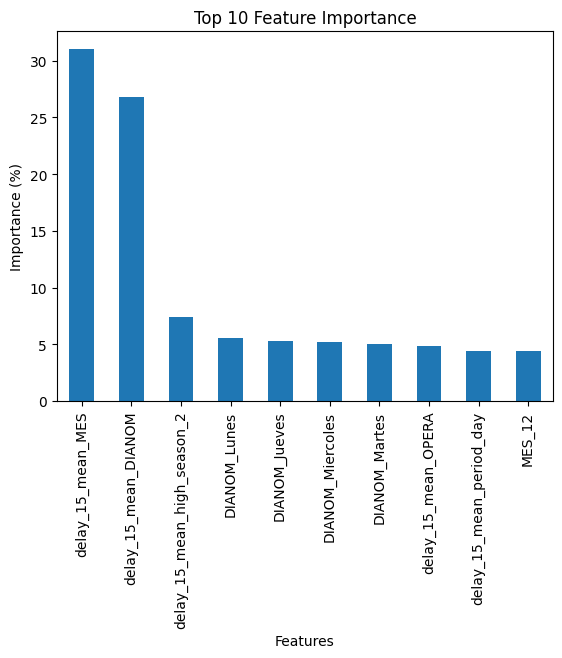

In [122]:
importance = xgb_model.get_score(importance_type='weight')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
df_importance = pd.DataFrame(importance, columns=['feature', 'score'])
total_score = df_importance['score'].sum()
df_importance['score'] = df_importance['score'] / total_score * 100
df_importance.plot(kind='bar', x='feature', y='score', legend=False)
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.show()

FINISH THIS PARRAGRPAH AND DONE

The top 5 most influential variables are:
- Delay rate per month (numeric)
- Delay rate per day of the week (numeric)
- Delay rate per high season (numeric)
- DIANOM_Lunes (categorical)
- DIANOM_Jueves (categorical)

The model captuted pattern generated by the time series. Better models for timeseries can be created. The approuched followed get ride of time series creating variables that capture the patterns, but is also possible to actually use the time series algorithms.

The model could be improved in various ways:
- Adding weather data. Is common that a flight get delayed because of bad weather or strong winds.
- In the same line: adding traffic data. Is common that a flight get delayed because of aero traffic.
- Also, might be useful to train a model with out many missing data. In other words, train a model where we have significant data to actually make an estimation. For that is important to check how much data is significant for a specific variable.